In [23]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

import yolo_utils


In [24]:
def yolo_filter_boxes(box_confidence , boxes, box_class_probs, threshold = 0.6):
    box_scores  = box_confidence * box_class_probs

    #第二步：找到最大值的锚框的索引以及对应的最大值的锚框的分数
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)

    #第三步：根据阈值创建掩码
    filtering_mask = (box_class_scores >= threshold)

    #对scores, boxes 以及 classes使用掩码
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)

    return scores , boxes , classes

In [25]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19,19,5,1], mean=1, stddev=4, seed=1)
    boxes = tf.random_normal([19,19,5,4],  mean=1, stddev=4, seed=1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)

    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

    test_a.close()


scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


In [26]:
def iou(box1, box2):
    xi1 = np.maximum(box1[0],box2[0])
    xi2 = np.minimum(box1[2],box2[2])
    yi1 = np.maximum(box1[1],box2[1])
    yi2 = np.minimum(box1[3],box2[3])
    inter_area = (xi1 - xi2) * (yi1 - yi2)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area
    return iou
    

In [27]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes=10, iou_threshold=0.5):
    max_boxes_tensor = K.variable(max_boxes,dtype="int32")
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold)
    scores = tf.gather(scores,nms_indices)
    boxes = tf.gather(boxes,nms_indices)
    classes = tf.gather(classes,nms_indices)
    return scores, boxes, classes

In [28]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)

    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

    test_b.close()

scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [29]:
def yolo_eval(yolo_outputs, image_shape=(720.,1280.), 
              max_boxes=10, score_threshold=0.6,iou_threshold=0.5):
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores , boxes , classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    boxes = yolo_utils.scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    return scores, boxes, classes

In [30]:
with tf.Session() as test_c:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)

    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

    test_c.close()

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [31]:
def predict(sess, image_file, is_show_info=True, is_plot=True):
    #图像预处理
    image, image_data = yolo_utils.preprocess_image("images/" + image_file, model_image_size = (608, 608))

    #运行会话并在feed_dict中选择正确的占位符.
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict = {yolo_model.input:image_data, K.learning_phase(): 0})

    #打印预测信息
    if is_show_info:
        print("在" + str(image_file) + "中找到了" + str(len(out_boxes)) + "个锚框。")

    #指定要绘制的边界框的颜色
    colors = yolo_utils.generate_colors(class_names)

    #在图中绘制边界框
    yolo_utils.draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)

    #保存已经绘制了边界框的图
    image.save(os.path.join("out", image_file), quality=100)

    #打印出已经绘制了边界框的图
    if is_plot:
        output_image = scipy.misc.imread(os.path.join("out", image_file))
        plt.imshow(output_image)

    return out_scores, out_boxes, out_classes

在0020.jpg中找到了1个锚框。
truck 0.75 (538, 286) (926, 413)


C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


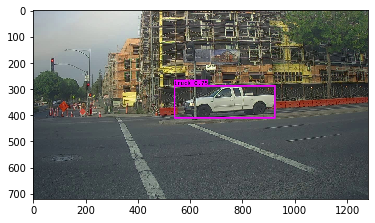

In [32]:
sess = K.get_session()
class_names = yolo_utils.read_classes("model_data/coco_classes.txt")
anchors = yolo_utils.read_anchors("model_data/yolo_anchors.txt")
image_shape = (720.,1280.)
yolo_model = load_model("model_data/yolov2.h5")
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)
out_scores, out_boxes, out_classes = predict(sess, "0020.jpg")
